In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 경로 및 설정
base_dir      = 'data'
time_slots    = ['morning', 'afternoon', 'evening']
holiday_dates = {'0603', '0606'}
year          = 2025

records = []
for date in sorted(os.listdir(base_dir)):
    if not date.isdigit(): continue
    for ts in time_slots:
        path = os.path.join(base_dir, date, f'delay_{date}_{ts}.csv')
        if not os.path.exists(path): continue
        df = pd.read_csv(path, parse_dates=['예정시간','실제시간'])
        df['날짜'] = date; df['시간대'] = ts
        dt = datetime.strptime(f'{year}{date}', '%Y%m%d')
        if date in holiday_dates:
            df['요일구분'] = '공휴일'
        elif dt.weekday() < 5:
            df['요일구분'] = '평일'
        else:
            df['요일구분'] = '주말'
        records.append(df)

all_df = pd.concat(records, ignore_index=True)
print(f"전체 레코드 수: {len(all_df):,} | 고유 역 수: {all_df['역사명'].nunique():,}")

전체 레코드 수: 1,055,098 | 고유 역 수: 400


In [30]:
# ──────────────────────────────────────────────
# Cell 2: 9호선 제거 + 지연여부 플래그 + 지연 10회 이하 역 필터
# ──────────────────────────────────────────────
# 9호선 제외
df = all_df[all_df['호선'] != '9호선'].copy()
# 지연 플래그
df['지연여부'] = df['지연시간(분)'] >= 1
print(f"9호선 제외 고유 역 수: {df['역사명'].nunique():,}")

# 평일/주말만, 지연건(>=1분)만 남긴 컬럼 생성
sub = df[df['요일구분'].isin(['평일','주말'])].copy()
sub['지연시간_지연건'] = sub['지연시간(분)'].where(sub['지연여부'], pd.NA)

# 역별 지연 발생 횟수 > 10회만
delay_counts = sub[sub['지연여부']].groupby('역사명').size()
valid_stations = delay_counts[delay_counts > 10].index
print(f"전체 역 수: {sub['역사명'].nunique():,} → 지연 10회 초과 역 수: {len(valid_stations):,}")
sub = sub[sub['역사명'].isin(valid_stations)]


9호선 제외 고유 역 수: 400
전체 역 수: 400 → 지연 10회 초과 역 수: 385


In [31]:
# ──────────────────────────────────────────────
# Cell 3: 피처 생성 (4개)
#   - mean_all, freq_all, ratio_mean_we_wd, ratio_freq_we_wd
# ──────────────────────────────────────────────
weekday_stats = sub[sub['요일구분']=='평일'] \
    .groupby('역사명') \
    .agg(mean_wd=('지연시간_지연건','mean'),
         freq_wd=('지연여부','mean'))

weekend_stats = sub[sub['요일구분']=='주말'] \
    .groupby('역사명') \
    .agg(mean_we=('지연시간_지연건','mean'),
         freq_we=('지연여부','mean'))

overall_stats = sub.groupby('역사명') \
    .agg(mean_all=('지연시간_지연건','mean'),
         freq_all=('지연여부','mean'))

feat = weekday_stats.join(weekend_stats, how='inner') \
                   .join(overall_stats, how='inner') \
                   .dropna()

feat['ratio_mean_we_wd'] = feat['mean_we'] / feat['mean_wd']
feat['ratio_freq_we_wd'] = feat['freq_we'] / feat['freq_wd']

feat_final = feat[['mean_all','freq_all','ratio_mean_we_wd','ratio_freq_we_wd']]
print(f"최종 남은 역 개수: {feat_final.shape[0]:,} | 피처 수: {feat_final.shape[1]}")


최종 남은 역 개수: 385 | 피처 수: 4


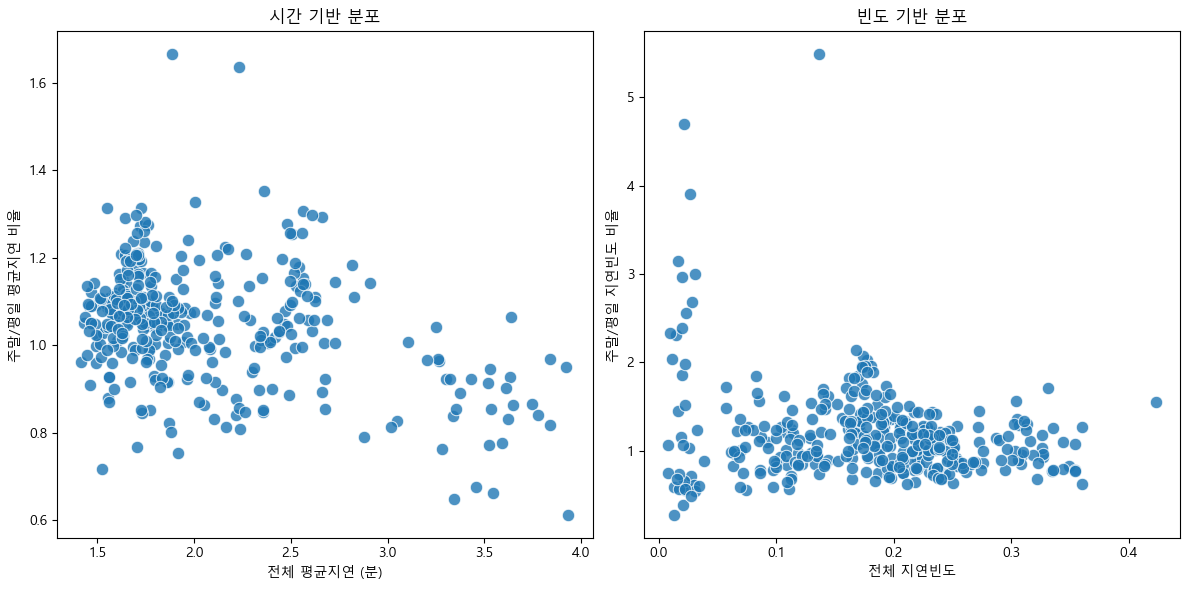

In [38]:
# ──────────────────────────────────────────────
# Cell 4: 클러스터링 전 2D Scatter Plots (시간 vs 빈도 구분)
#   - 좌: 시간 기반 (mean_all vs ratio_mean_we_wd)
#   - 우: 빈도 기반 (freq_all vs ratio_freq_we_wd)
# ──────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# 시간 기반
sns.scatterplot(
    data=feat_final.reset_index(),
    x='mean_all', y='ratio_mean_we_wd',
    s=80, alpha=0.8, ax=axes[0]
)
axes[0].set_title('시간 기반 분포')
axes[0].set_xlabel('전체 평균지연 (분)')
axes[0].set_ylabel('주말/평일 평균지연 비율')

# 빈도 기반
sns.scatterplot(
    data=feat_final.reset_index(),
    x='freq_all', y='ratio_freq_we_wd',
    s=80, alpha=0.8, ax=axes[1]
)
axes[1].set_title('빈도 기반 분포')
axes[1].set_xlabel('전체 지연빈도')
axes[1].set_ylabel('주말/평일 지연빈도 비율')

plt.tight_layout()
plt.show()


In [42]:
# ──────────────────────────────────────────────
# Cell 5: KMeans 클러스터링
# ──────────────────────────────────────────────
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = feat_final.values
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
feat_final['cluster'] = kmeans.fit_predict(X_scaled)
print("클러스터별 역 개수:\n", feat_final['cluster'].value_counts())


클러스터별 역 개수:
 cluster
0    198
1    118
3     56
2     13
Name: count, dtype: int64


C:\Users\yanghm\AppData\Local\Temp\ipykernel_17100\3433301660.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_final['cluster'] = kmeans.fit_predict(X_scaled)


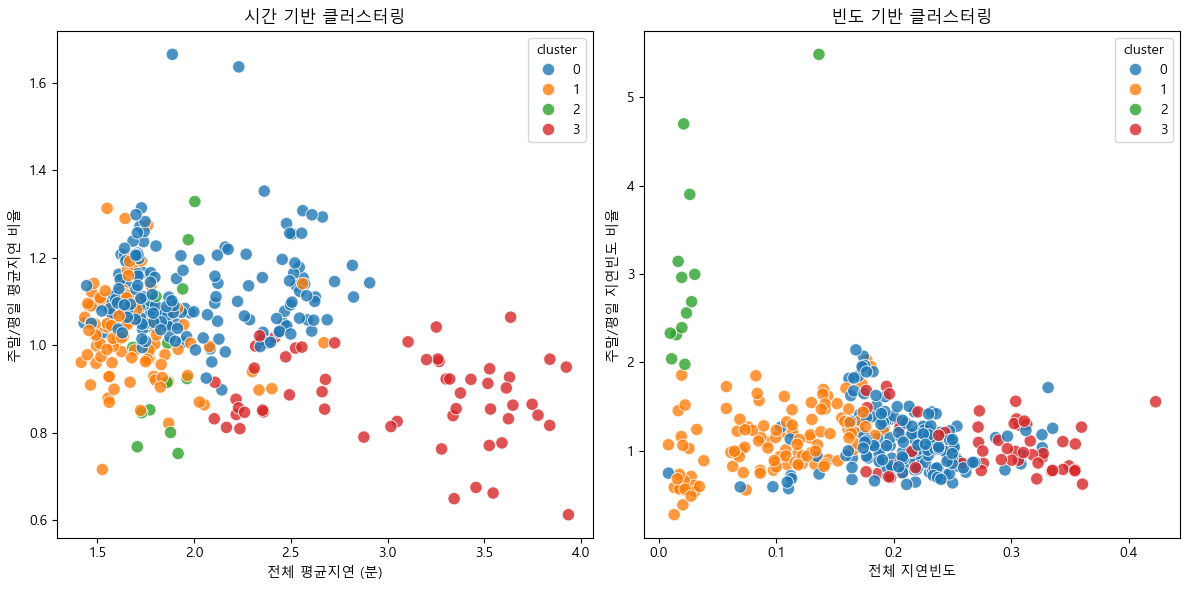

In [43]:
# ──────────────────────────────────────────────
# Cell 6: 클러스터링 후 2D Scatter Plots
#   - 좌: 시간 기반 (mean_all vs ratio_mean_we_wd)
#   - 우: 빈도 기반 (freq_all vs ratio_freq_we_wd)
# ──────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# 시간 기반 (클러스터 색상)
sns.scatterplot(
    data=feat_final.reset_index(),
    x='mean_all', y='ratio_mean_we_wd',
    hue='cluster', palette='tab10',
    s=80, alpha=0.8, ax=axes[0]
)
axes[0].set_title('시간 기반 클러스터링')
axes[0].set_xlabel('전체 평균지연 (분)')
axes[0].set_ylabel('주말/평일 평균지연 비율')

# 빈도 기반 (클러스터 색상)
sns.scatterplot(
    data=feat_final.reset_index(),
    x='freq_all', y='ratio_freq_we_wd',
    hue='cluster', palette='tab10',
    s=80, alpha=0.8, ax=axes[1]
)
axes[1].set_title('빈도 기반 클러스터링')
axes[1].set_xlabel('전체 지연빈도')
axes[1].set_ylabel('주말/평일 지연빈도 비율')

plt.tight_layout()
plt.show()


In [44]:
# ──────────────────────────────────────────────
# Cell 7: 클러스터별 역 개수 확인
# ──────────────────────────────────────────────
print("클러스터별 역 개수:\n", feat_final['cluster'].value_counts())

클러스터별 역 개수:
 cluster
0    198
1    118
3     56
2     13
Name: count, dtype: int64


In [45]:
# Cell 8: 결과 CSV로 저장
feat_final.to_csv('cluster_results.csv', index=True, encoding='utf-8-sig')
print("클러스터링 결과를 cluster_results.csv로 저장했습니다.")

클러스터링 결과를 cluster_results.csv로 저장했습니다.


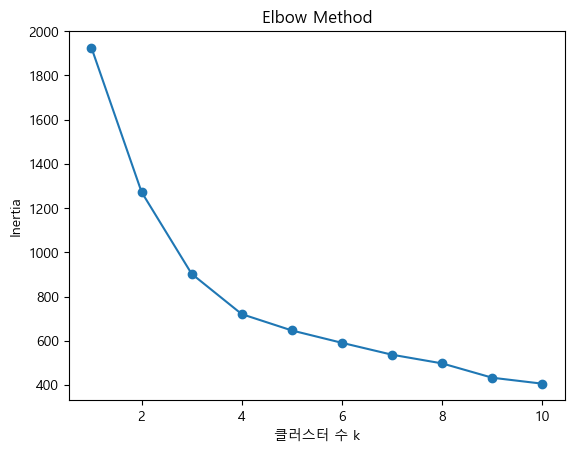

In [39]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, 'o-')
plt.xlabel('클러스터 수 k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

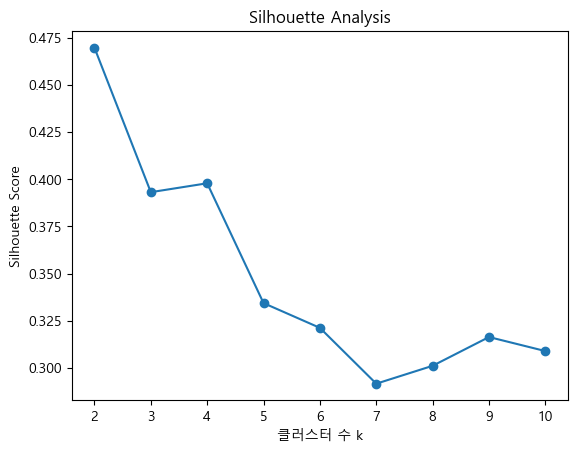

In [40]:
from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(2, 11)  # Silhouette는 k>=2
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

plt.plot(K_range, sil_scores, 'o-')
plt.xlabel('클러스터 수 k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

전체 레코드 수: 1,055,098 | 고유 역 수: 0          1-가능
1          1-가능
2          1-가능
3          1-가능
4          1-가능
           ... 
1055093    9-흑석
1055094    9-흑석
1055095    9-흑석
1055096    9-흑석
1055097    9-흑석
Length: 1055098, dtype: object
필터 후 레코드 수: 903,863 | 고유 (호선-역) 조합 수: 435
최종 남은 (호선-역) 조합: 435개 | 피처 수: 4


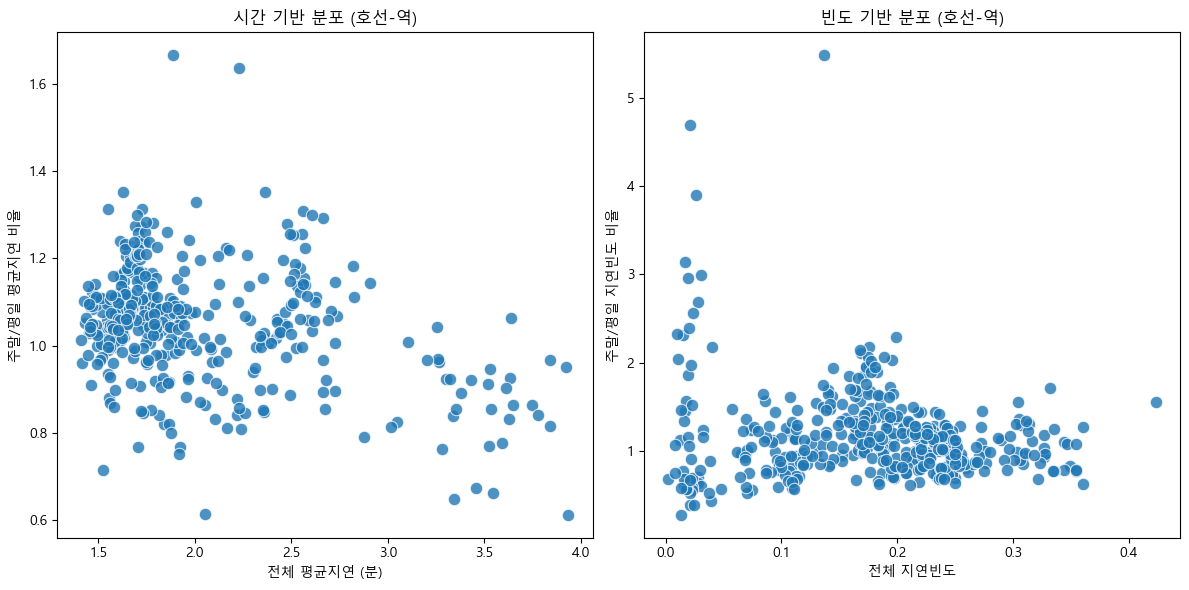

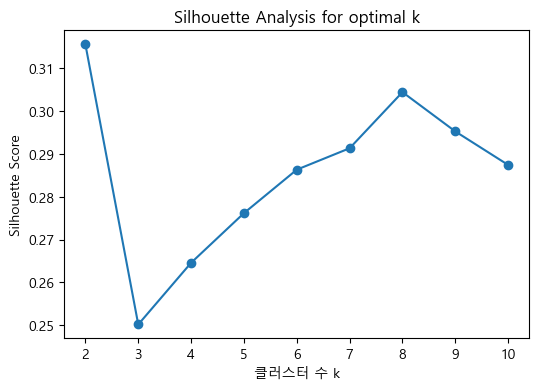

클러스터별 (호선-역) 조합 수:
 cluster
0    135
4     76
6     69
5     54
7     51
1     37
3     10
2      3
Name: count, dtype: int64
저장 완료: cluster_results_line_station.csv


C:\Users\yanghm\AppData\Local\Temp\ipykernel_17100\4141957128.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_final['cluster'] = KMeans(n_clusters=k_opt, random_state=42).fit_predict(X_scaled)


In [47]:
# Updated Jupyter Notebook Cells: “호선 + 역” 조합으로 클러스터링

# ──────────────────────────────────────────────
# Cell 1: 라이브러리 로드 및 all_df 생성
# ──────────────────────────────────────────────
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 한글 폰트 설정 (Windows: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 경로 및 설정
base_dir      = 'data'
time_slots    = ['morning', 'afternoon', 'evening']
holiday_dates = {'0603', '0606'}
year          = 2025

records = []
for date in sorted(os.listdir(base_dir)):
    if not date.isdigit(): continue
    for ts in time_slots:
        path = os.path.join(base_dir, date, f'delay_{date}_{ts}.csv')
        if not os.path.exists(path): continue
        df = pd.read_csv(path, parse_dates=['예정시간','실제시간'])
        df['날짜'] = date
        df['시간대'] = ts
        dt = datetime.strptime(f'{year}{date}', '%Y%m%d')
        if date in holiday_dates:
            df['요일구분'] = '공휴일'
        elif dt.weekday() < 5:
            df['요일구분'] = '평일'
        else:
            df['요일구분'] = '주말'
        records.append(df)

all_df = pd.concat(records, ignore_index=True)
print(f"전체 레코드 수: {len(all_df):,} | 고유 역 수: {all_df['호선'].astype(str) + '-' + all_df['역사명']}")

# ──────────────────────────────────────────────
# Cell 2: 9호선 제외 + 지연여부 플래그 + 지연 10회 이하 역 필터
# ──────────────────────────────────────────────
df = all_df[all_df['호선'] != '9호선'].copy()
df['지연여부'] = df['지연시간(분)'] >= 1

sub = df[df['요일구분'].isin(['평일','주말'])].copy()
sub['지연시간_지연건'] = sub['지연시간(분)'].where(sub['지연여부'], pd.NA)

delay_counts = sub[sub['지연여부']].groupby(['호선','역사명']).size()
valid = delay_counts[delay_counts > 10].index
sub = sub.set_index(['호선','역사명']).loc[valid].reset_index()

print(f"필터 후 레코드 수: {len(sub):,} | 고유 (호선-역) 조합 수: {valid.shape[0]}")

# ──────────────────────────────────────────────
# Cell 3: 피처 생성 (4개)
#   - mean_all, freq_all, ratio_mean_we_wd, ratio_freq_we_wd
# ──────────────────────────────────────────────
weekday_stats = sub[sub['요일구분']=='평일'].groupby(['호선','역사명']) \
    .agg(mean_wd=('지연시간_지연건','mean'),
         freq_wd=('지연여부','mean'))

weekend_stats = sub[sub['요일구분']=='주말'].groupby(['호선','역사명']) \
    .agg(mean_we=('지연시간_지연건','mean'),
         freq_we=('지연여부','mean'))

overall_stats = sub.groupby(['호선','역사명']) \
    .agg(mean_all=('지연시간_지연건','mean'),
         freq_all=('지연여부','mean'))

feat = weekday_stats.join(weekend_stats, how='inner') \
                   .join(overall_stats, how='inner') \
                   .reset_index()

# 비율 파생
feat['ratio_mean_we_wd'] = feat['mean_we'] / feat['mean_wd']
feat['ratio_freq_we_wd'] = feat['freq_we'] / feat['freq_wd']

feat_final = feat[['호선','역사명','mean_all','freq_all','ratio_mean_we_wd','ratio_freq_we_wd']]

print(f"최종 남은 (호선-역) 조합: {feat_final.shape[0]}개 | 피처 수: {feat_final.shape[1] - 2}")
# 호선과 역사명 제외하고 실제 피처는 4개입니다.

# ──────────────────────────────────────────────
# Cell 4: 클러스터링 전 2D Scatter Plot (시간 vs 빈도)
# ──────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 시간 기반: 전체 평균지연 vs 주말/평일 평균지연 비율
sns.scatterplot(
    data=feat_final,
    x='mean_all', y='ratio_mean_we_wd',
    s=80, alpha=0.8, ax=axes[0]
)
axes[0].set_title('시간 기반 분포 (호선-역)')
axes[0].set_xlabel('전체 평균지연 (분)')
axes[0].set_ylabel('주말/평일 평균지연 비율')

# 빈도 기반: 전체 지연빈도 vs 주말/평일 지연빈도 비율
sns.scatterplot(
    data=feat_final,
    x='freq_all', y='ratio_freq_we_wd',
    s=80, alpha=0.8, ax=axes[1]
)
axes[1].set_title('빈도 기반 분포 (호선-역)')
axes[1].set_xlabel('전체 지연빈도')
axes[1].set_ylabel('주말/평일 지연빈도 비율')

plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────
# Cell 5: 최적 k 자동 탐색 (예: Silhouette)
# ──────────────────────────────────────────────
from sklearn.metrics import silhouette_score

X = feat_final[['mean_all','freq_all','ratio_mean_we_wd','ratio_freq_we_wd']].values
X_scaled = StandardScaler().fit_transform(X)

sil_scores = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, 'o-')
plt.xticks(K_range)
plt.title('Silhouette Analysis for optimal k')
plt.xlabel('클러스터 수 k')
plt.ylabel('Silhouette Score')
plt.show()

# ──────────────────────────────────────────────
# Cell 6: KMeans 클러스터링 (예: k=3)
# ──────────────────────────────────────────────
k_opt = 8
feat_final['cluster'] = KMeans(n_clusters=k_opt, random_state=42).fit_predict(X_scaled)

# ──────────────────────────────────────────────
# Cell 7: 클러스터별 조합 수 확인
# ──────────────────────────────────────────────
print("클러스터별 (호선-역) 조합 수:\n", feat_final['cluster'].value_counts())

# ──────────────────────────────────────────────
# Cell 8: CSV로 저장
# ──────────────────────────────────────────────
feat_final.to_csv('cluster_results_line_station.csv', index=False, encoding='utf-8-sig')
print("저장 완료: cluster_results_line_station.csv")


In [54]:
# ──────────────────────────────────────────────
# Cell 7: DBSCAN 클러스터링
# ──────────────────────────────────────────────
from sklearn.cluster import DBSCAN

# 이미 X_scaled, feat_final이 정의되어 있다고 가정
# eps: 이웃으로 볼 최대 거리, min_samples: 최소 샘플 수
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
feat_final['dbscan_label'] = dbscan.fit_predict(X_scaled)

# 클러스터 개수(노이즈 제외)
n_clusters = len(set(feat_final['dbscan_label'])) - (1 if -1 in feat_final['dbscan_label'] else 0)
print(f"DBSCAN으로 찾은 클러스터 수: {n_clusters}")
print("각 레이블별 샘플 수:\n", feat_final['dbscan_label'].value_counts())

DBSCAN으로 찾은 클러스터 수: 12
각 레이블별 샘플 수:
 dbscan_label
 2     215
-1     117
 0      29
 7      17
 1      14
 3       8
 5       8
 6       7
 4       5
 8       5
 9       5
 10      5
Name: count, dtype: int64


C:\Users\yanghm\AppData\Local\Temp\ipykernel_17100\4179315274.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_final['dbscan_label'] = dbscan.fit_predict(X_scaled)


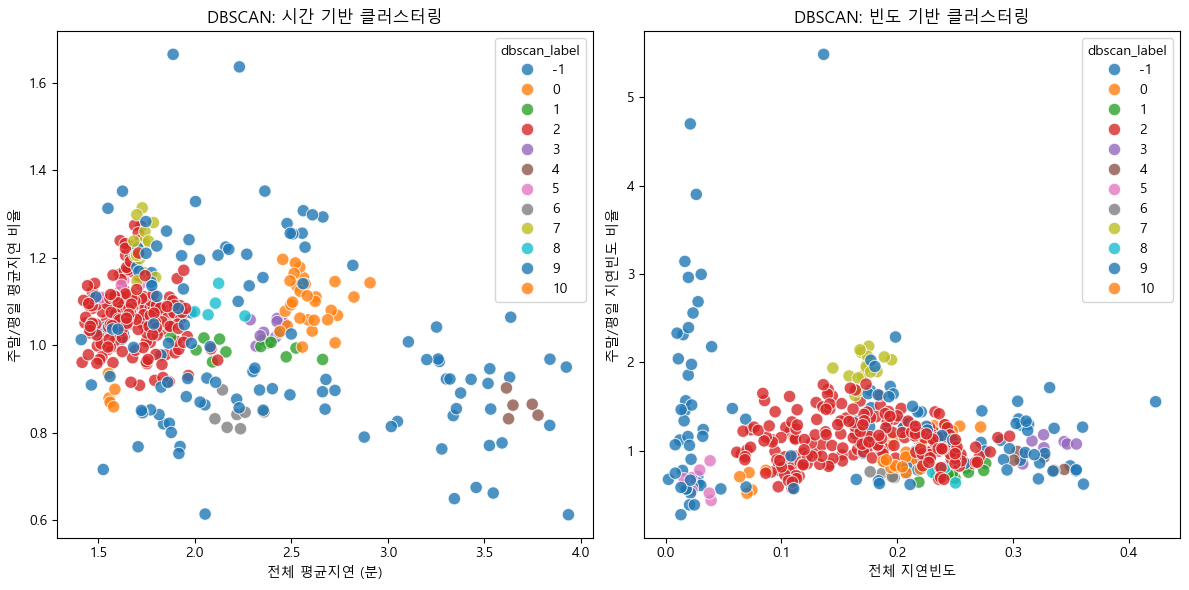

In [55]:
# ──────────────────────────────────────────────
# Cell 8: DBSCAN 결과 2D Scatter Plots
# ──────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# 시간 기반 (mean_all vs ratio_mean_we_wd)
sns.scatterplot(
    data=feat_final.reset_index(),
    x='mean_all', y='ratio_mean_we_wd',
    hue='dbscan_label', palette='tab10',
    s=80, alpha=0.8, ax=axes[0]
)
axes[0].set_title('DBSCAN: 시간 기반 클러스터링')
axes[0].set_xlabel('전체 평균지연 (분)')
axes[0].set_ylabel('주말/평일 평균지연 비율')

# 빈도 기반 (freq_all vs ratio_freq_we_wd)
sns.scatterplot(
    data=feat_final.reset_index(),
    x='freq_all', y='ratio_freq_we_wd',
    hue='dbscan_label', palette='tab10',
    s=80, alpha=0.8, ax=axes[1]
)
axes[1].set_title('DBSCAN: 빈도 기반 클러스터링')
axes[1].set_xlabel('전체 지연빈도')
axes[1].set_ylabel('주말/평일 지연빈도 비율')

plt.tight_layout()
plt.show()


최종 피처 목록: ['mean_all', 'freq_all', 'ratio_mean_we_wd', 'ratio_freq_we_wd', 'cluster', 'dbscan_label', 'mean_td_afternoon', 'mean_td_evening', 'mean_td_morning', 'freq_td_afternoon', 'freq_td_evening', 'freq_td_morning']


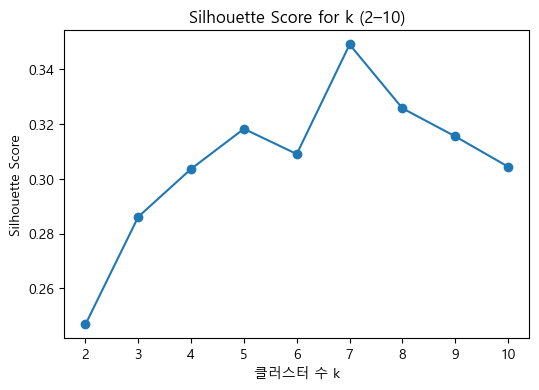

클러스터별 (호선-역) 조합 수:
 cluster
0    133
4    113
2     68
5     37
1     35
6     25
3     22
Name: count, dtype: int64
클러스터 결과 저장: cluster_results_10features.csv


In [63]:
# Cell 8: 10개 피처 기반 K-Means 클러스터링

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 이전에 정의된 sub, feat_final(DataFrame) 기준으로 실행하세요.

# 1) 시간대별 통계 (아침/오후/저녁)
tod = sub.groupby(['호선','역사명','시간대']).agg(
    mean_td=('지연시간_지연건','mean'),
    freq_td=('지연여부','mean')
).reset_index()

tod_pivot = tod.pivot(index=['호선','역사명'], 
                      columns='시간대', 
                      values=['mean_td','freq_td'])
tod_pivot.columns = [f"{stat}_{td}" for stat, td in tod_pivot.columns]

# 2) 기존 4개 피처와 결합
feat4 = feat_final.set_index(['호선','역사명'])
feat10 = feat4.join(tod_pivot, how='inner').dropna()

print("최종 피처 목록:", feat10.columns.tolist())

# 3) 스케일링
X10 = feat10.values
X_scaled = StandardScaler().fit_transform(X10)

# 4) Silhouette 분석으로 최적 k 탐색
sil_scores = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, 'o-')
plt.title('Silhouette Score for k (2–10)')
plt.xlabel('클러스터 수 k')
plt.ylabel('Silhouette Score')
plt.show()

# 5) K-Means 클러스터링 (예: k_opt=3 선택)
k_opt = 7
kmeans = KMeans(n_clusters=k_opt, random_state=42)
feat10['cluster'] = kmeans.fit_predict(X_scaled)

print("클러스터별 (호선-역) 조합 수:\n", feat10['cluster'].value_counts())

# 6) 결과 CSV 저장
feat10.reset_index().to_csv('cluster_results_10features.csv', index=False, encoding='utf-8-sig')
print("클러스터 결과 저장: cluster_results_10features.csv")


is_transfer     False     True 
cluster                        
0            0.744361  0.255639
1            1.000000  0.000000
2            0.911765  0.088235
3            0.818182  0.181818
4            0.690265  0.309735
5            0.621622  0.378378
6            0.720000  0.280000


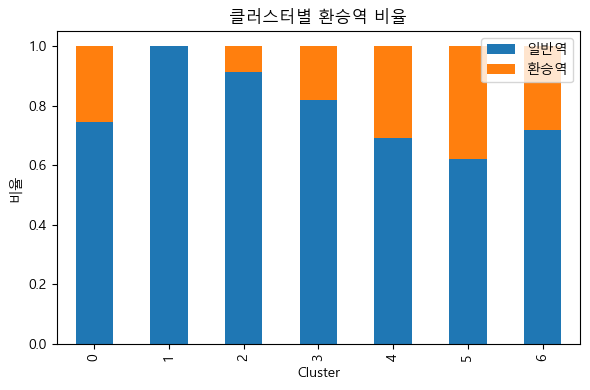

In [64]:
# 1) 역사명별 호선 수 계산 (중복 제거 후)
transfer_counts = all_df[['호선','역사명']] \
    .drop_duplicates() \
    .groupby('역사명') \
    .size() \
    .reset_index(name='line_count')

# 2) 환승역 여부 플래그 추가 (호선 수 ≥ 2)
transfer_counts['is_transfer'] = transfer_counts['line_count'] >= 2

# 3) feat10에 병합 (feat10은 ['호선','역사명', 10개 피처, 'cluster'] 를 갖고 있어야 함)
feat_tf = feat10.reset_index().merge(
    transfer_counts[['역사명','is_transfer']],
    on='역사명',
    how='left'
)

# 4) 클러스터별 환승역 비율 확인
import pandas as pd, matplotlib.pyplot as plt

ct = pd.crosstab(feat_tf['cluster'], feat_tf['is_transfer'], normalize='index')
print(ct)

# 5) 시각화
ct.plot(kind='bar', stacked=True, figsize=(6,4))
plt.title('클러스터별 환승역 비율')
plt.xlabel('Cluster')
plt.ylabel('비율')
plt.legend(['일반역','환승역'], loc='upper right')
plt.tight_layout()
plt.show()


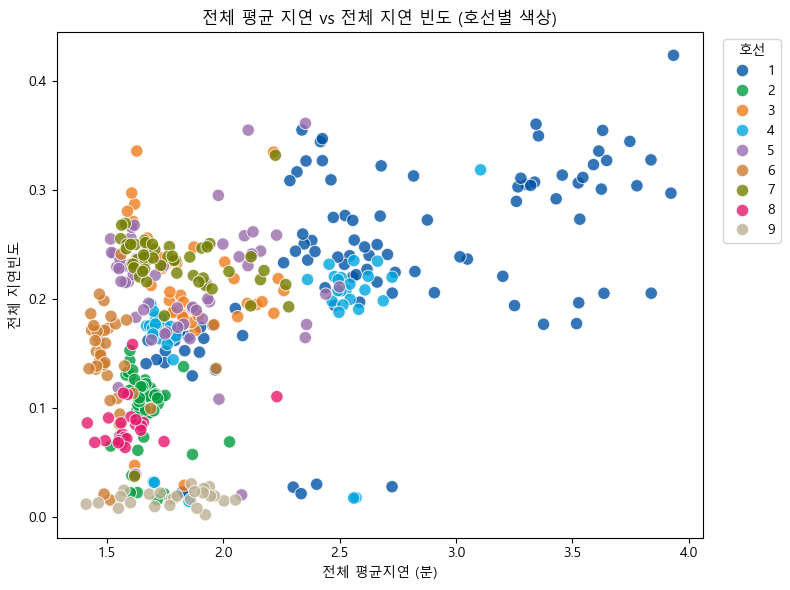

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────
# 호선별 색상 매핑 (Pantone → Hex 근사값)
# ──────────────────────────────────────────────
line_colors_int = {
    1: '#0052A4',
    2: '#009D3E',
    3: '#EF7C1C',
    4: '#00A5DE',
    5: '#996CAC',
    6: '#CD7C2F',
    7: '#747F00',
    8: '#E6186C',
    9: '#BDB092',
}

# feat10 에 '호선', 'mean_all', 'freq_all' 등이 있다고 가정
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=feat10.reset_index(),
    x='mean_all', y='freq_all',
    hue='호선',               # 정수 1~9
    palette=line_colors_int,  # {1: hex, …}
    s=80, alpha=0.8
)
plt.title('전체 평균 지연 vs 전체 지연 빈도 (호선별 색상)')
plt.xlabel('전체 평균지연 (분)')
plt.ylabel('전체 지연빈도')
plt.legend(title='호선', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()


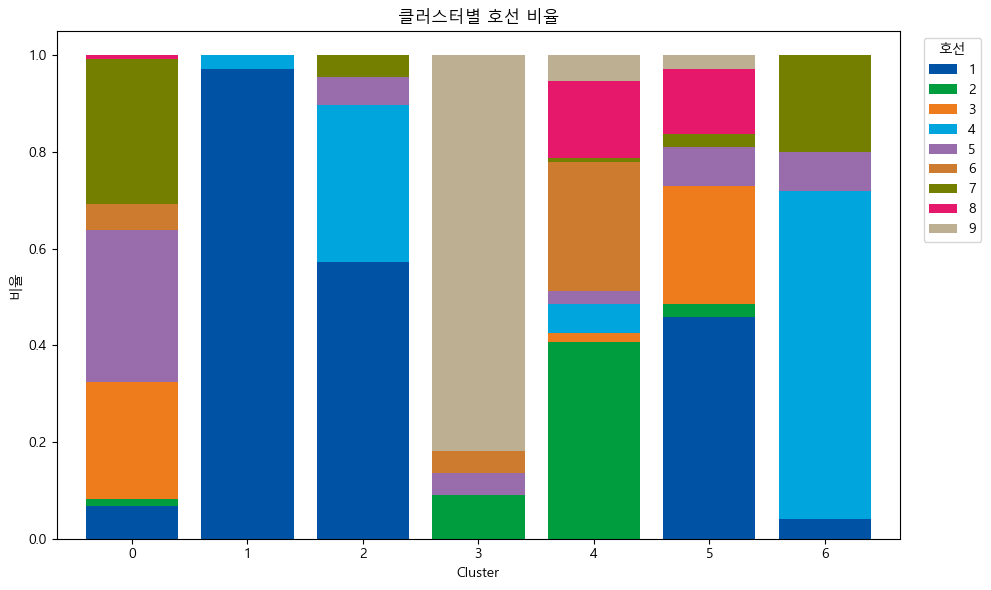

In [73]:
# ──────────────────────────────────────────────
# Cell 11: 클러스터별 호선 비율 스택형 바 차트 (line_colors_int 사용)
# ──────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

# 1) feat10 불러오기 (인덱스 풀기)
df_plot = feat10.reset_index()

# 2) 클러스터별 호선 비율 계산 (행별 정규화)
ct_line = pd.crosstab(df_plot['cluster'], df_plot['호선'], normalize='index')

# 3) 공식 색상 매핑 (정수 키)
line_colors_int = {
    1: '#0052A4',
    2: '#009D3E',
    3: '#EF7C1C',
    4: '#00A5DE',
    5: '#996CAC',
    6: '#CD7C2F',
    7: '#747F00',
    8: '#E6186C',
    9: '#BDB092',
}

# 4) 컬럼 순서대로 색상 리스트 생성
colors = [ line_colors_int[line] for line in ct_line.columns ]

# 5) 스택형 바 차트
ax = ct_line.plot(
    kind='bar',
    stacked=True,
    color=colors,
    figsize=(10, 6),
    width=0.8
)

ax.set_title('클러스터별 호선 비율')
ax.set_xlabel('Cluster')
ax.set_ylabel('비율')
ax.legend(title='호선', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) 데이터 로드
base_dir      = 'data'
time_slots    = ['morning', 'afternoon', 'evening']
holiday_dates = {'0603', '0606'}
year          = 2025
records = []
for date in sorted(os.listdir(base_dir)):
    if not date.isdigit(): continue
    for ts in time_slots:
        path = os.path.join(base_dir, date, f'delay_{date}_{ts}.csv')
        if not os.path.exists(path): continue
        df = pd.read_csv(path, parse_dates=['예정시간','실제시간'])
        df['날짜'] = date
        df['시간대'] = ts
        dt = datetime.strptime(f'{year}{date}', '%Y%m%d')
        if date in holiday_dates:
            df['요일구분'] = '공휴일'
        elif dt.weekday() < 5:
            df['요일구분'] = '평일'
        else:
            df['요일구분'] = '주말'
        records.append(df)
all_df = pd.concat(records, ignore_index=True)

# 평일/주말만 사용
all_df = all_df[all_df['요일구분'].isin(['평일','주말'])].copy()

# 2) 지연 기준 2분 -> 플래그, 지연건 지연시간 컬럼
threshold = 2
all_df['지연여부'] = all_df['지연시간(분)'] >= threshold
all_df['지연_건_지연시간'] = all_df['지연시간(분)'].where(all_df['지연여부'], np.nan)

# 3) (호선,역사명)별 피처 계산
grp = all_df.groupby(['호선','역사명'])
overall = grp.agg(mean_all=('지연_건_지연시간','mean'),
                  freq_all=('지연여부','mean'))
weekday = all_df[all_df['요일구분']=='평일'].groupby(['호선','역사명']).agg(
    mean_wd=('지연_건_지연시간','mean'),
    freq_wd=('지연여부','mean')
)
weekend = all_df[all_df['요일구분']=='주말'].groupby(['호선','역사명']).agg(
    mean_we=('지연_건_지연시간','mean'),
    freq_we=('지연여부','mean')
)
morning = all_df[all_df['시간대']=='morning'].groupby(['호선','역사명']).agg(
    mean_morn=('지연_건_지연시간','mean')
)
afternoon = all_df[all_df['시간대']=='afternoon'].groupby(['호선','역사명']).agg(
    mean_aft=('지연_건_지연시간','mean')
)
evening = all_df[all_df['시간대']=='evening'].groupby(['호선','역사명']).agg(
    mean_eve=('지연_건_지연시간','mean')
)

feat = overall.join([weekday, weekend, morning, afternoon, evening], how='inner').reset_index()
feat['ratio_mean_we_wd'] = feat['mean_we'] / feat['mean_wd']
feat['ratio_freq_we_wd'] = feat['freq_we'] / feat['freq_wd']
feat['ratio_eve_morn'] = feat['mean_eve'] / feat['mean_morn']
feat['ratio_eve_aft'] = feat['mean_eve'] / feat['mean_aft']

# NA/inf 제거
feat.replace([np.inf, -np.inf], np.nan, inplace=True)
feat.dropna(inplace=True)

# 4) 스케일링 & KMeans++ 클러스터링
features = ['mean_all','freq_all','ratio_mean_we_wd','ratio_freq_we_wd','ratio_eve_morn','ratio_eve_aft']
X_scaled = StandardScaler().fit_transform(feat[features])
k = 3  # 클러스터 수 조정 가능
feat['cluster'] = KMeans(n_clusters=k, init='k-means++', random_state=42).fit_predict(X_scaled)

# 5) 결과 확인 및 저장
print(feat[['호선','역사명','cluster'] + features].head())
print("\n클러스터별 조합 수:\n", feat['cluster'].value_counts())
feat.to_csv('cluster_line_station_kmeanspp.csv', index=False, encoding='utf-8-sig')
print("\nSaved: cluster_line_station_kmeanspp.csv")


   호선      역사명  cluster  mean_all  freq_all  ratio_mean_we_wd  \
0   1       가능        2  3.824242  0.148248          1.006802   
1   1  가산디지털단지        2  3.670670  0.153253          1.033433   
2   1       간석        1  3.358451  0.168847          1.009784   
3   1       개봉        1  3.307234  0.144972          1.034473   
4   1       관악        2  3.294406  0.178484          1.019128   

   ratio_freq_we_wd  ratio_eve_morn  ratio_eve_aft  
0          1.710000        0.975832       0.931793  
1          0.667133        0.836914       0.746499  
2          1.229206        1.099671       1.030858  
3          0.956923        1.132366       1.098334  
4          0.927325        0.899062       0.885214  

클러스터별 조합 수:
 cluster
0    270
2     74
1     65
Name: count, dtype: int64

Saved: cluster_line_station_kmeanspp.csv
